## Grandient Boosting Modeling for Reading ##

The models are:
- CatBoost
- XGBoost
- LightGBM
- HistGradientBoosting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# import warnings 
# warnings.filterwarnings('ignore')

# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score

### Prepare data ###

Loading the data cleaned from [EDA.ipynb](../processing/EDA.ipynb)

In [3]:
df = pd.read_csv('../processing/DATA_Texas_District_v2.csv', sep=',', header=0)
print(df.shape)

(955, 90)


Loading the Feature Selection result report from [Feature_Selection_Reading.ipynb](../processing/Feature_Selection_Reading.ipynb)

In [4]:
report = pd.read_csv('../processing/Feature_Selection_Reading_Report.csv', sep=',', header=0)
report = report.sort_values(by=['MCC', 'F1'], ascending=False, ignore_index=True)
print(report.shape)

(85, 10)


**Get dummies for categorical feature `Locale`**

In [5]:
df = pd.get_dummies(df, columns=['Locale'], prefix='Locale')
print(df.shape)

(955, 101)


**Split data**

In [6]:
labels = ['Label_Math', 'Label_Reading', 'Label_All']
cols_drop = ['% Tested Math G3 Diff',
            '% Tested Math G4 Diff',
            '% Tested Math G5 Diff',
            '% Tested Math G6 Diff',
            '% Tested Math G7 Diff',
            '% Tested Math G8 Diff',
            'District #', 'County #']


df['Label'] = df['Label_Reading'].apply(lambda x: 0 if x == -1
                                             else 1 if x == 0
                                             else 2)

y = df['Label'].values
X = df.drop(columns=labels + cols_drop + ['Label']).copy()
columns = df.drop(columns=labels + cols_drop + ['Label']).columns.to_list()
categorical_cols = [c for c in columns if 'Locale' in c]
categorical_cols_idx = [columns.index(c) for c in columns if 'Locale' in c]
numerical_cols = [c for c in columns if c not in categorical_cols]

random_state=123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=random_state, shuffle=True)
print(X.shape)

(955, 90)


In [7]:
values, counts = np.unique(y_train, return_counts=True)
values_test, counts_test = np.unique(y_test, return_counts=True)
pd.DataFrame({'Label': values.tolist(), 'Train': counts.tolist(), 'Test': counts_test.tolist()})

,Label,Train,Test
0,0,173,43
1,1,409,102
2,2,182,46


**Normalization**

In [8]:
# scaler = StandardScaler()

# scaler.fit(X_train[numerical_cols])
# X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
# X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

### Experiment with the Feature Sets selected from [Feature_Selection_Reading.ipynb](../processing/Feature_Selection_Reading.ipynb) ###

In [9]:
print('Feature Set 1 (Original Set)')
print('\tn features:', len(columns))

feature_set = report[(report['model'] == 'Ridge') & (report['type'] == 'by methods')].sort_values(by=['n Selected'], ignore_index=True)
n = feature_set.shape[0]

for i in range(n):
    print('Feature Set', str(i+2))
    print('\tn features: {:0.0f}'.format(feature_set.loc[i, 'n Selected']))
    if feature_set.loc[i, 'type'] == 'by counts': 
        print('\tSelected by {:0.0f} methods'.format(feature_set.loc[i, 'Counts']))

Feature Set 1 (Original Set)
	n features: 90
Feature Set 2
	n features: 5
Feature Set 3
	n features: 20
Feature Set 4
	n features: 26
Feature Set 5
	n features: 36
Feature Set 6
	n features: 45
Feature Set 7
	n features: 45
Feature Set 8
	n features: 45
Feature Set 9
	n features: 51
Feature Set 10
	n features: 82


**n iteration for models**

In [10]:
def get_n_iter (param_grid):
    n_iter_ratio = 0.2
    n_iter = 1
    for v in param_grid.values(): n_iter*=len(v)
    n_iter *= n_iter_ratio

    return int(n_iter)

### Modeling ###

In [11]:
rounds = 20

In [12]:
def model_report(estimator, param_grid, name, fit_params):
    result = pd.DataFrame()
    avg = 'weighted'
    cv=5
    
    n_iter=get_n_iter(param_grid)
    print('{} n_iter: {:0.0f}'.format(name, n_iter))     
    if name == 'CatBoost': n_iter=100
        
    for i in range(n+1):
        if i == n: 
            features = columns
            method = 'No Reduction'
        else: 
            features = list(feature_set.loc[i, 'features'].strip("[]''").split("', '"))
            method = feature_set.loc[i, 'Method']
         
        X_train2 = X_train.loc[:, features].copy()
        X_test2 = X_test.loc[:, features].copy()        
                
        categorical_cols_inx=[features.index(f) for f in features if f in categorical_cols]
        if len(categorical_cols_inx) > 0:
            if (name == 'LightGBM'): fit_params['categorical_feature']=categorical_cols_inx
            if (name == 'CatBoost'): fit_params['cat_features']=categorical_cols_inx
            if (name == 'HistGB'): estimator.set_params(**{'categorical_features': categorical_cols_inx})
            if (name == 'XGBoost'):
                X_train2=X_train2.astype({features[c]: 'category' for c in categorical_cols_inx})
                X_test2=X_test2.astype({features[c]: 'category' for c in categorical_cols_inx})
        else: 
            if (name == 'LightGBM'): fit_params['categorical_feature']=None
            if (name == 'CatBoost'): fit_params['cat_features']=None
            if (name == 'HistGB'): estimator.set_params(**{'categorical_features': None})

        grid = RandomizedSearchCV(estimator, param_distributions=param_grid, cv=cv, n_jobs=-1, 
                              random_state=random_state, n_iter=n_iter)

        start_cpu = time.process_time()
        start_wall = time.time()
        
        if name == 'HistGB': 
            grid.fit(X_train2, y_train)
        elif name == 'LightGBM':
            fit_params['eval_set'] =  [(X_test2.values, y_test)]
            grid.fit(X_train2.values, y_train, **fit_params)
        else:
            fit_params['eval_set'] =  [(X_test2, y_test)]
            grid.fit(X_train2, y_train, **fit_params)            
       
        if name == 'XGBoost': grid.best_estimator_.save_model("categorical-model.json")
            
        cpu_time = time.process_time() - start_cpu
        wall_time = time.time() - start_wall
        y_pred = grid.best_estimator_.predict(X_test2)
        
        temp = {'Model': name,
                'n Selected': len(features),
                'Method': method,
                'best_params': grid.best_params_,
                'Best Accuracy': grid.best_score_, 
                'Train Accuracy': grid.best_estimator_.score(X_train2, y_train),
                'Test Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, average=avg),
                'Recall': recall_score(y_test, y_pred, average=avg),
                'MCC': matthews_corrcoef(y_test, y_pred), 
                'F1': f1_score(y_test, y_pred, average=avg),
#                 'ROC': roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test2), multi_class='ovr', average=avg),
                'conf_mat': confusion_matrix(y_test, y_pred), 
                'Prediction': y_pred,
                'predict_proba': grid.best_estimator_.predict_proba(X_test2),
                'Features': features,
                'estimator': grid.best_estimator_,
                'classification_report': classification_report(y_test, y_pred),
                'Train Time CPU': cpu_time,
                'Train Time Wall': wall_time,
                'n_iter': n_iter}
        result = pd.concat([result, pd.DataFrame([temp])], ignore_index=True)
    return result

In [13]:
results = pd.DataFrame()

**CatBoost**

In [14]:
%%time
from catboost import CatBoostClassifier

params = {'iterations': [50, 100, 200],
'depth': [3, 6, 9],
'min_data_in_leaf': [1, 5, 10],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'l2_leaf_reg': [0, 0.01, 0.1, 1, 10],
'random_strength': [0, 5, 10, 15]}

fit_params = {'early_stopping_rounds': rounds}

estimator = CatBoostClassifier(random_seed=random_state, verbose=False, 
                               loss_function='MultiClass', eval_metric="MultiClass", one_hot_max_size=4, border_count=254)
                               
result_report=model_report(estimator, params, 'CatBoost', fit_params)
results=pd.concat([results, result_report], ignore_index=True)

CatBoost n_iter: 432


C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\sit

CPU times: total: 1min 31s
Wall time: 1h 53min 6s


**XGBoost**

In [15]:
%%time
import xgboost

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, 0],
'min_child_weight': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'alpha': [0,  0.1, 10],
'lambda': [0,  0.1, 10],
'gamma': [0,  0.1, 10]}

estimator = xgboost.XGBClassifier(seed=random_state, objective='multi:softproba', eval_metric='mlogloss', use_label_encoder=False, verbosity=0,
                                  num_class=3, tree_method="hist", early_stopping_rounds=rounds, enable_categorical=True, max_cat_to_onehot=4)

result_report=model_report(estimator, params, 'XGBoost', {})
results=pd.concat([results, result_report], ignore_index=True)

XGBoost n_iter: 777
[0]	validation_0-mlogloss:1.05165
[1]	validation_0-mlogloss:1.02491
[2]	validation_0-mlogloss:0.99913
[3]	validation_0-mlogloss:0.98228
[4]	validation_0-mlogloss:0.96595
[5]	validation_0-mlogloss:0.95309
[6]	validation_0-mlogloss:0.94537
[7]	validation_0-mlogloss:0.93441
[8]	validation_0-mlogloss:0.92998
[9]	validation_0-mlogloss:0.92501
[10]	validation_0-mlogloss:0.92064
[11]	validation_0-mlogloss:0.91729
[12]	validation_0-mlogloss:0.91250
[13]	validation_0-mlogloss:0.91003
[14]	validation_0-mlogloss:0.90808
[15]	validation_0-mlogloss:0.90539
[16]	validation_0-mlogloss:0.90423
[17]	validation_0-mlogloss:0.90452
[18]	validation_0-mlogloss:0.90425
[19]	validation_0-mlogloss:0.90453
[20]	validation_0-mlogloss:0.90378
[21]	validation_0-mlogloss:0.90406
[22]	validation_0-mlogloss:0.90387
[23]	validation_0-mlogloss:0.90334
[24]	validation_0-mlogloss:0.90394
[25]	validation_0-mlogloss:0.90323
[26]	validation_0-mlogloss:0.90415
[27]	validation_0-mlogloss:0.90432
[28]	valid

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\sit

[0]	validation_0-mlogloss:1.05768
[1]	validation_0-mlogloss:1.02962
[2]	validation_0-mlogloss:1.01217
[3]	validation_0-mlogloss:0.99749
[4]	validation_0-mlogloss:0.98868
[5]	validation_0-mlogloss:0.98432
[6]	validation_0-mlogloss:0.97922
[7]	validation_0-mlogloss:0.97806
[8]	validation_0-mlogloss:0.97367
[9]	validation_0-mlogloss:0.97296
[10]	validation_0-mlogloss:0.97465
[11]	validation_0-mlogloss:0.97310
[12]	validation_0-mlogloss:0.97250
[13]	validation_0-mlogloss:0.97157
[14]	validation_0-mlogloss:0.97093
[15]	validation_0-mlogloss:0.97177
[16]	validation_0-mlogloss:0.97009
[17]	validation_0-mlogloss:0.97267
[18]	validation_0-mlogloss:0.97487
[19]	validation_0-mlogloss:0.97671
[20]	validation_0-mlogloss:0.97746
[21]	validation_0-mlogloss:0.97739
[22]	validation_0-mlogloss:0.97739
[23]	validation_0-mlogloss:0.97739
[24]	validation_0-mlogloss:0.97739
[25]	validation_0-mlogloss:0.97739
[26]	validation_0-mlogloss:0.97739
[27]	validation_0-mlogloss:0.97739
[28]	validation_0-mlogloss:0.9

[86]	validation_0-mlogloss:0.97623
[87]	validation_0-mlogloss:0.97537
[88]	validation_0-mlogloss:0.97463
[89]	validation_0-mlogloss:0.97397
[90]	validation_0-mlogloss:0.97329
[91]	validation_0-mlogloss:0.97263
[92]	validation_0-mlogloss:0.97182
[93]	validation_0-mlogloss:0.97116
[94]	validation_0-mlogloss:0.97061
[95]	validation_0-mlogloss:0.96984
[96]	validation_0-mlogloss:0.96924
[97]	validation_0-mlogloss:0.96857
[98]	validation_0-mlogloss:0.96784
[99]	validation_0-mlogloss:0.96713
[100]	validation_0-mlogloss:0.96637
[101]	validation_0-mlogloss:0.96573
[102]	validation_0-mlogloss:0.96515
[103]	validation_0-mlogloss:0.96439
[104]	validation_0-mlogloss:0.96366
[105]	validation_0-mlogloss:0.96315
[106]	validation_0-mlogloss:0.96248
[107]	validation_0-mlogloss:0.96198
[108]	validation_0-mlogloss:0.96120
[109]	validation_0-mlogloss:0.96056
[110]	validation_0-mlogloss:0.95999
[111]	validation_0-mlogloss:0.95957
[112]	validation_0-mlogloss:0.95888
[113]	validation_0-mlogloss:0.95827
[114]	

[118]	validation_0-mlogloss:0.93578
[119]	validation_0-mlogloss:0.93528
[120]	validation_0-mlogloss:0.93536
[121]	validation_0-mlogloss:0.93490
[122]	validation_0-mlogloss:0.93502
[123]	validation_0-mlogloss:0.93402
[124]	validation_0-mlogloss:0.93377
[125]	validation_0-mlogloss:0.93327
[126]	validation_0-mlogloss:0.93274
[127]	validation_0-mlogloss:0.93227
[128]	validation_0-mlogloss:0.93166
[129]	validation_0-mlogloss:0.93097
[130]	validation_0-mlogloss:0.93010
[131]	validation_0-mlogloss:0.92963
[132]	validation_0-mlogloss:0.92900
[133]	validation_0-mlogloss:0.92825
[134]	validation_0-mlogloss:0.92751
[135]	validation_0-mlogloss:0.92678
[136]	validation_0-mlogloss:0.92614
[137]	validation_0-mlogloss:0.92542
[138]	validation_0-mlogloss:0.92463
[139]	validation_0-mlogloss:0.92390
[140]	validation_0-mlogloss:0.92325
[141]	validation_0-mlogloss:0.92255
[142]	validation_0-mlogloss:0.92187
[143]	validation_0-mlogloss:0.92128
[144]	validation_0-mlogloss:0.92069
[145]	validation_0-mlogloss:

[121]	validation_0-mlogloss:0.95448
[122]	validation_0-mlogloss:0.95415
[123]	validation_0-mlogloss:0.95363
[124]	validation_0-mlogloss:0.95331
[125]	validation_0-mlogloss:0.95303
[126]	validation_0-mlogloss:0.95252
[127]	validation_0-mlogloss:0.95207
[128]	validation_0-mlogloss:0.95161
[129]	validation_0-mlogloss:0.95123
[130]	validation_0-mlogloss:0.95082
[131]	validation_0-mlogloss:0.95039
[132]	validation_0-mlogloss:0.95009
[133]	validation_0-mlogloss:0.94979
[134]	validation_0-mlogloss:0.94942
[135]	validation_0-mlogloss:0.94910
[136]	validation_0-mlogloss:0.94868
[137]	validation_0-mlogloss:0.94844
[138]	validation_0-mlogloss:0.94809
[139]	validation_0-mlogloss:0.94798
[140]	validation_0-mlogloss:0.94768
[141]	validation_0-mlogloss:0.94743
[142]	validation_0-mlogloss:0.94704
[143]	validation_0-mlogloss:0.94675
[144]	validation_0-mlogloss:0.94654
[145]	validation_0-mlogloss:0.94611
[146]	validation_0-mlogloss:0.94582
[147]	validation_0-mlogloss:0.94569
[148]	validation_0-mlogloss:

**LightGBM**

In [16]:
%%time
import lightgbm as lgb

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, -1],
'min_sum_hessian_in_leaf': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'reg_alpha': [0,  0.1, 10],
'reg_lambda': [0,  0.1, 10],
'min_split_gain': [0,  0.1, 10]}

fit_params = {'early_stopping_rounds': rounds}

estimator = lgb.LGBMClassifier(random_state=random_state, objective="multiclass", metric="multi_logloss", verbosity=-1, silent=True, force_col_wise=True,
                               num_class=3, is_unbalance=True, max_cat_threshold=32)
                               
result_report=model_report(estimator, params, 'LightGBM', fit_params)
results=pd.concat([results, result_report], ignore_index=True)

LightGBM n_iter: 777
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[1]	valid_0's multi_logloss: 0.996237
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.981803
[3]	valid_0's multi_logloss: 0.969623
[4]	valid_0's multi_logloss: 0.962042
[5]	valid_0's multi_logloss: 0.953406
[6]	valid_0's multi_logloss: 0.945208
[7]	valid_0's multi_logloss: 0.939095
[8]	valid_0's multi_logloss: 0.934447
[9]	valid_0's multi_logloss: 0.92889
[10]	valid_0's multi_logloss: 0.924869
[11]	valid_0's multi_logloss: 0.919495
[12]	valid_0's multi_logloss: 0.916387
[13]	valid_0's multi_logloss: 0.913801
[14]	valid_0's multi_logloss: 0.911521
[15]	valid_0's multi_logloss: 0.909465
[16]	valid_0's multi_logloss: 0.908179
[17]	valid_0's multi_logloss: 0.906402
[18]	valid_0's multi_logloss: 0.90624
[19]	valid_0's multi_logloss: 0.90449
[20]	valid_0's multi_logloss: 0.904554
[21]	v

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\sit

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[1]	valid_0's multi_logloss: 0.994385
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.988592
[3]	valid_0's multi_logloss: 0.976741
[4]	valid_0's multi_logloss: 0.975261
[5]	valid_0's multi_logloss: 0.975262
[6]	valid_0's multi_logloss: 0.975473
[7]	valid_0's multi_logloss: 0.979666
[8]	valid_0's multi_logloss: 0.985293
[9]	valid_0's multi_logloss: 0.99484
[10]	valid_0's multi_logloss: 0.999037
[11]	valid_0's multi_logloss: 0.998174
[12]	valid_0's multi_logloss: 0.995255
[13]	valid_0's multi_logloss: 0.99972
[14]	valid_0's multi_logloss: 1.00407
[15]	valid_0's multi_logloss: 1.00322
[16]	valid_0's multi_logloss: 1.00103
[17]	valid_0's multi_logloss: 1.00766
[18]	valid_0's multi_logloss: 1.00756
[19]	valid_0's multi_logloss: 1.00864
[20]	valid_0's multi_logloss: 1.01433
[21]	valid_0's multi_logloss: 1.01879

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [19, 20, 21, 22, 32, 33]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[1]	valid_0's multi_logloss: 0.999253
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.986933
[3]	valid_0's multi_logloss: 0.975622
[4]	valid_0's multi_logloss: 0.96605
[5]	valid_0's multi_logloss: 0.958574
[6]	valid_0's multi_logloss: 0.956753
[7]	valid_0's multi_logloss: 0.947585
[8]	valid_0's multi_logloss: 0.942542
[9]	valid_0's multi_logloss: 0.940562
[10]	valid_0's multi_logloss: 0.936833
[11]	valid_0's multi_logloss: 0.931849
[12]	valid_0's multi_logloss: 0.929622
[13]	valid_0's multi_logloss: 0.926475
[14]	valid_0's multi_logloss: 0.928839
[15]	valid_0's multi_logloss: 0.926582
[16]	valid_0's multi_logloss: 0.924478
[17]	valid_0's multi_logloss: 0.926459
[18]	valid_0's multi_logloss: 0.929543
[19]	valid_0's multi_logloss: 0.929447
[20]	valid_0's multi_logloss: 0.929762
[21]	valid_0's multi_logloss: 0.9

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [22, 23, 24, 25, 34, 35, 36, 37, 38, 39, 40, 41]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[1]	valid_0's multi_logloss: 0.982559
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.962299
[3]	valid_0's multi_logloss: 0.948671
[4]	valid_0's multi_logloss: 0.937835
[5]	valid_0's multi_logloss: 0.932585
[6]	valid_0's multi_logloss: 0.92912
[7]	valid_0's multi_logloss: 0.923734
[8]	valid_0's multi_logloss: 0.92085
[9]	valid_0's multi_logloss: 0.91682
[10]	valid_0's multi_logloss: 0.913934
[11]	valid_0's multi_logloss: 0.912163
[12]	valid_0's multi_logloss: 0.911583
[13]	valid_0's multi_logloss: 0.909243
[14]	valid_0's multi_logloss: 0.907788
[15]	valid_0's multi_logloss: 0.909491
[16]	valid_0's multi_logloss: 0.908086
[17]	valid_0's multi_logloss: 0.907466
[18]	valid_0's multi_logloss: 0.906018
[19]	valid_0's multi_logloss: 0.905392
[20]	valid_0's multi_logloss: 0.904765
[21]	valid_0's multi_logloss: 0

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [22, 23, 24, 25, 34, 35, 36, 37, 38, 39, 40, 41]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[1]	valid_0's multi_logloss: 0.963438
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.947158
[3]	valid_0's multi_logloss: 0.94489
[4]	valid_0's multi_logloss: 0.936028
[5]	valid_0's multi_logloss: 0.932066
[6]	valid_0's multi_logloss: 0.933026
[7]	valid_0's multi_logloss: 0.93755
[8]	valid_0's multi_logloss: 0.941978
[9]	valid_0's multi_logloss: 0.955673
[10]	valid_0's multi_logloss: 0.956945
[11]	valid_0's multi_logloss: 0.964017
[12]	valid_0's multi_logloss: 0.966956
[13]	valid_0's multi_logloss: 0.978249
[14]	valid_0's multi_logloss: 0.982616
[15]	valid_0's multi_logloss: 0.986762
[16]	valid_0's multi_logloss: 0.984052
[17]	valid_0's multi_logloss: 0.995336
[18]	valid_0's multi_logloss: 0.999372
[19]	valid_0's multi_logloss: 1.00498
[20]	valid_0's multi_logloss: 1.0126
[21]	valid_0's multi_logloss: 1.0

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [31, 32, 33, 34, 56, 57, 58, 59, 60]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[1]	valid_0's multi_logloss: 0.970009
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.944989
[3]	valid_0's multi_logloss: 0.924156
[4]	valid_0's multi_logloss: 0.927494
[5]	valid_0's multi_logloss: 0.916905
[6]	valid_0's multi_logloss: 0.91563
[7]	valid_0's multi_logloss: 0.912901
[8]	valid_0's multi_logloss: 0.916406
[9]	valid_0's multi_logloss: 0.924489
[10]	valid_0's multi_logloss: 0.928275
[11]	valid_0's multi_logloss: 0.93663
[12]	valid_0's multi_logloss: 0.942001
[13]	valid_0's multi_logloss: 0.949268
[14]	valid_0's multi_logloss: 0.955285
[15]	valid_0's multi_logloss: 0.961143
[16]	valid_0's multi_logloss: 0.966388
[17]	valid_0's multi_logloss: 0.972002
[18]	valid_0's multi_logloss: 0.974859
[19]	valid_0's multi_logloss: 0.974188
[20]	valid_0's multi_logloss: 0.97405
[21]	valid_0's multi_loglos

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


**HistGradientBoosting**

In [17]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

params = {'max_iter': [50, 100, 200],
'max_depth': [1, 6, None],
'max_leaf_nodes': [10, 31, 50, 64],
'min_samples_leaf': [10, 20, 30],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'l2_regularization': [0, 0.01, 0.1, 1, 10]}

estimator=HistGradientBoostingClassifier(random_state=random_state, n_iter_no_change=rounds, early_stopping=True)
result_report=model_report(estimator, params, 'HistGB', {})
results=pd.concat([results, result_report], ignore_index=True)

HistGB n_iter: 432
CPU times: total: 2min 40s
Wall time: 11min 50s


## Result ##

In [18]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)[['Model', 'Method', 'n Selected', 'Test Accuracy', 'MCC', 'F1', 'best_params']]

,Model,Method,n Selected,Test Accuracy,MCC,F1,best_params
8,CatBoost,Permutation Importance - Ridge,82,0.623037,0.337826,0.547543,"{'random_strength': 5, 'min_data_in_leaf': 5, ..."
19,XGBoost,No Reduction,90,0.612565,0.311846,0.534661,"{'n_estimators': 200, 'min_child_weight': 0.00..."
18,XGBoost,Permutation Importance - Ridge,82,0.602094,0.288245,0.541117,"{'n_estimators': 50, 'min_child_weight': 0.1, ..."
29,LightGBM,No Reduction,90,0.602094,0.288108,0.516374,"{'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimat..."
25,LightGBM,Feature Importance - Random Forest,45,0.596859,0.273488,0.529833,"{'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estim..."
10,XGBoost,RFE - Ridge,5,0.591623,0.265926,0.502555,"{'n_estimators': 100, 'min_child_weight': 0, '..."
3,CatBoost,RFE - Random Forest,36,0.591623,0.263592,0.515893,"{'random_strength': 0, 'min_data_in_leaf': 5, ..."
23,LightGBM,RFE - Random Forest,36,0.591623,0.263317,0.528309,"{'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimat..."
2,CatBoost,Permutation Importance - Random Forest,26,0.586387,0.253217,0.529265,"{'random_strength': 15, 'min_data_in_leaf': 1,..."
28,LightGBM,Permutation Importance - Ridge,82,0.575916,0.249042,0.533271,"{'reg_lambda': 10, 'reg_alpha': 0, 'n_estimato..."


In [19]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)['Model'].value_counts().to_frame()

,Model
LightGBM,4
CatBoost,3
XGBoost,3


In [20]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)['n Selected'].value_counts().sort_index().to_frame()

,n Selected
5,1
26,1
36,2
45,1
82,3
90,2


**Accuracy, MCC and F1 Score**

In [21]:
results2 = pd.DataFrame()
for col in ['Train Accuracy', 'Test Accuracy', 'MCC', 'F1']:
    temp = results[['Model', 'n Selected'] + [col]].copy()
    temp['Score'] = col
    temp.rename(columns={col: 'Score value'}, inplace=True)
    results2 = pd.concat([results2, temp], ignore_index=True)
results2=results2.astype({'n Selected': 'int32'})

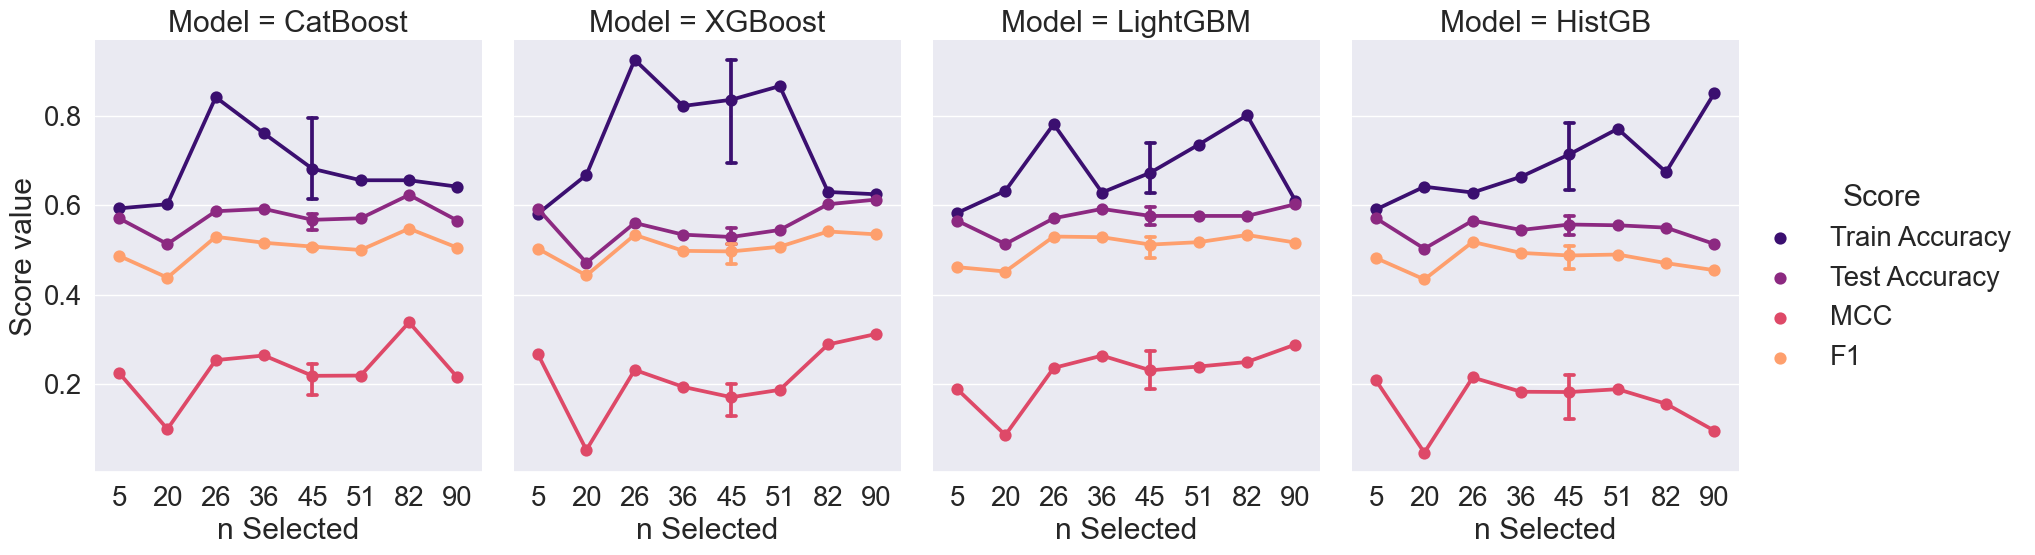

In [22]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style='whitegrid')
sns.set(font_scale=1.8)

g = sns.catplot(x="n Selected", y="Score value", hue="Score", col="Model",
                capsize=.2, palette="magma", height=6, aspect=.75,
                kind="point", data=results2)
g.despine(left=True)
plt.show()

In [23]:
models = results['Model'].unique().tolist()
temp=results.sort_values(by=['Model', 'MCC', 'F1'], ascending=False)

best_per_model_idx = []
for i in range(len(temp.index)):
    if i % (n+1) == 0: best_per_model_idx.append(temp.index[i])

**Confusion Matrix**

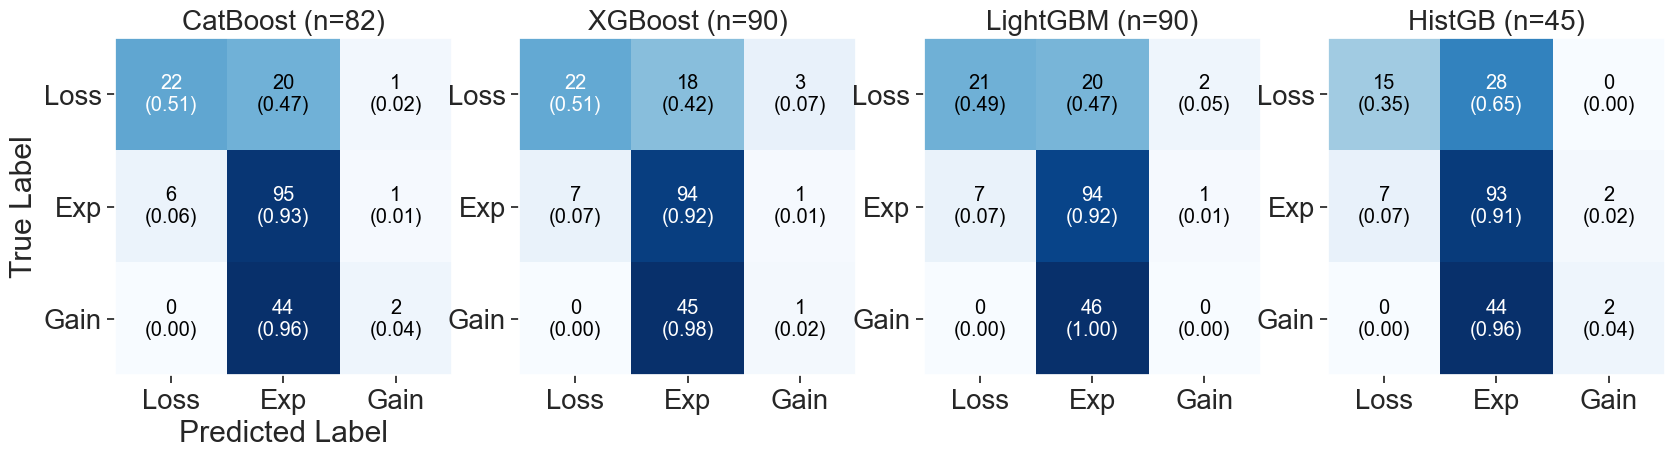

In [24]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.ticker as mticker

def ticks(x, position):
    if position == 1: return 'Loss'
    if position == 2: return 'Exp'
    if position == 3: return 'Gain'
    
fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,10))
sns.set(font_scale=1.2)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    plot_confusion_matrix(axis=axes[i], conf_mat=results.loc[idx, 'conf_mat'],
                          show_absolute=True, show_normed=True)
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    if (i > 0): axes[i].set(xlabel='', ylabel='')
    else : axes[i].set(xlabel='Predicted Label', ylabel='True Label')
    axes[i].xaxis.set_major_formatter(mticker.FuncFormatter(ticks))
    axes[i].yaxis.set_major_formatter(mticker.FuncFormatter(ticks))
plt.show()

**ROC Curve**

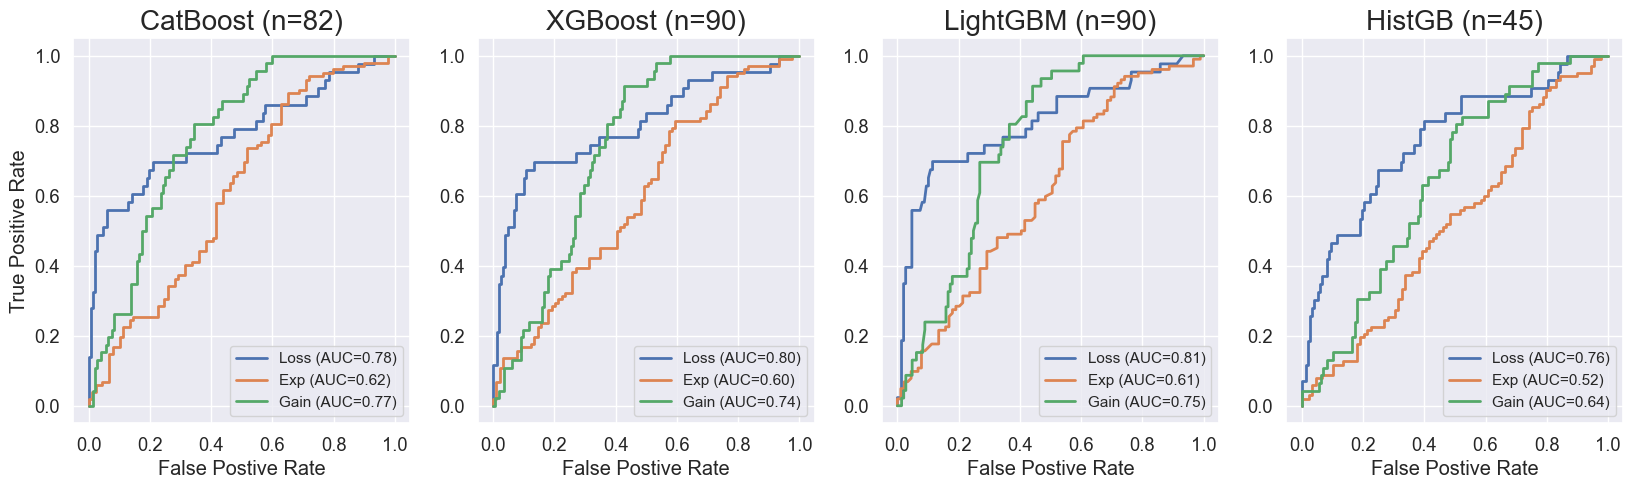

In [25]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes=[0, 1, 2]
y_test_bin=label_binarize(y_test, classes=classes)

fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,5))
sns.set(font_scale=1)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    fpr, tpr = {}, {}

    for c in classes:
        fpr[c], tpr[c], _ = roc_curve(y_test_bin[:, c], results.loc[idx, 'predict_proba'][:, c])
        axes[i].plot(fpr[c], tpr[c], lw=2, label='{} (AUC={:0.2f})'.format(ticks(c,c+1), auc(fpr[c], tpr[c])))
    
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    axes[i].set_xlabel("False Postive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[i].legend(loc="best")

plt.show()

**Precision-Recall Curve**

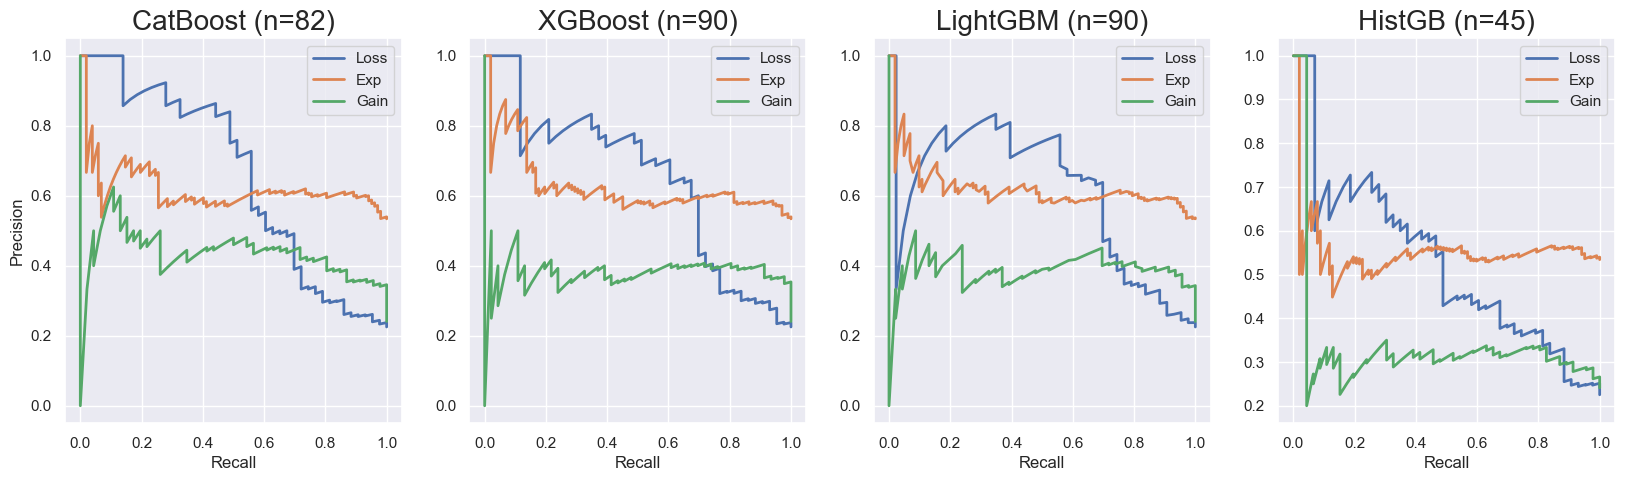

In [26]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

classes=[0, 1, 2]
y_test_bin=label_binarize(y_test, classes=classes)

fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,5))
sns.set(font_scale=1)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    prec, rec = {}, {}

    for c in classes:
        prec[c], rec[c], _ = precision_recall_curve(y_test_bin[:, c], results.loc[idx, 'predict_proba'][:, c])
        axes[i].plot(rec[c], prec[c], lw=2, label='{}'.format(ticks(c,c+1)))
    
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    axes[i].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[i].legend(loc="best")

plt.show()

In [27]:
for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    print(title, '\n', results.loc[idx, 'classification_report'])

CatBoost (n=82) 
               precision    recall  f1-score   support

           0       0.79      0.51      0.62        43
           1       0.60      0.93      0.73       102
           2       0.50      0.04      0.08        46

    accuracy                           0.62       191
   macro avg       0.63      0.50      0.48       191
weighted avg       0.62      0.62      0.55       191

XGBoost (n=90) 
               precision    recall  f1-score   support

           0       0.76      0.51      0.61        43
           1       0.60      0.92      0.73       102
           2       0.20      0.02      0.04        46

    accuracy                           0.61       191
   macro avg       0.52      0.48      0.46       191
weighted avg       0.54      0.61      0.53       191

LightGBM (n=90) 
               precision    recall  f1-score   support

           0       0.75      0.49      0.59        43
           1       0.59      0.92      0.72       102
           2       0.0

In [28]:
results.sort_values(by=['MCC'], ascending=False).to_csv('Modeling_GB_Reading.csv', index=False)